# Compute symptom-disease cooccurrence for Hetionet

In [1]:
import io
import gzip

import pandas
import requests
import networkx

import eutility
import cooccurrence

In [2]:
# Read mappings for DO Slim terms
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/xrefs-slim.tsv'
disease_df = pandas.read_table(url)
disease_df = disease_df.query('resource == "MSH"').drop('resource', 1)
disease_df = disease_df.rename(columns={'resource_id': 'mesh_id'})

# Read MeSH terms to MeSH names
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/terms.tsv'
mesh_df = pandas.read_table(url)
disease_df = disease_df.merge(mesh_df)

# Manually remove problematic xrefs
# https://github.com/obophenotype/human-disease-ontology/issues/45
disease_df = disease_df.query("mesh_id != 'D003327' and mesh_id != 'D017202'")
disease_df.head()

,doid_code,doid_name,mesh_id,mesh_name
0,DOID:2531,hematologic cancer,D019337,Hematologic Neoplasms
1,DOID:1319,brain cancer,D001932,Brain Neoplasms
2,DOID:1324,lung cancer,D008175,Lung Neoplasms
3,DOID:263,kidney cancer,D007680,Kidney Neoplasms
4,DOID:1793,pancreatic cancer,D010190,Pancreatic Neoplasms


# Diseases

In [3]:
rows_out = list()

for i, row in disease_df.iterrows():
    term_query = '{disease}[MeSH Major Topic]'.format(disease = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 10000)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

disease_pmids_df = pandas.DataFrame(rows_out)

7382 articles for Hematologic Neoplasms
99586 articles for Brain Neoplasms
139299 articles for Lung Neoplasms
49515 articles for Kidney Neoplasms
46298 articles for Pancreatic Neoplasms
85654 articles for Skin Neoplasms
83658 articles for Bone Neoplasms
22125 articles for Pharyngeal Neoplasms
53989 articles for Ovarian Neoplasms
188908 articles for Breast Neoplasms
49539 articles for Glioma
89055 articles for Uterine Neoplasms
18514 articles for Adrenal Gland Neoplasms
33421 articles for Esophageal Neoplasms
12158 articles for Salivary Gland Neoplasms
83257 articles for Prostatic Neoplasms
64512 articles for Stomach Neoplasms
37569 articles for Urinary Bladder Neoplasms
14765 articles for Peripheral Nervous System Neoplasms
33286 articles for Thyroid Neoplasms
97650 articles for Liver Neoplasms
50220 articles for Uterine Cervical Neoplasms
3507 articles for Vaginal Neoplasms
210249 articles for Head and Neck Neoplasms
32809 articles for Rectal Neoplasms
28761 articles for Eye Neoplasms

In [4]:
with gzip.open('data/disease-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    disease_pmids_df.to_csv(write_file, sep='\t', index=False)

# Symptoms

In [5]:
# Read MeSH Symptoms
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/symptoms.tsv'
symptom_df = pandas.read_table(url)
symptom_df.head()

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0
2,D000326,Adrenoleukodystrophy,0
3,D000334,Aerophagy,1
4,D000370,Ageusia,1


In [6]:
rows_out = list()

for i, row in symptom_df.iterrows():
    term_query = '{symptom}[MeSH Terms:noexp]'.format(symptom = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

8496 articles for Abdomen, Acute
313 articles for Adie Syndrome
1508 articles for Adrenoleukodystrophy
261 articles for Aerophagy
222 articles for Ageusia
2049 articles for Agnosia
849 articles for Agraphia
12310 articles for Albuminuria
1118 articles for Alcohol Amnestic Disorder
846 articles for Alkalosis, Respiratory
5803 articles for Amblyopia
6330 articles for Amnesia
824 articles for Amnesia, Retrograde
30785 articles for Angina Pectoris
1864 articles for Angina Pectoris, Variant
8277 articles for Angina, Unstable
933 articles for Anomia
4130 articles for Anorexia
3055 articles for Olfaction Disorders
53502 articles for Anoxia
8561 articles for Aphasia
1439 articles for Aphasia, Broca
825 articles for Aphasia, Wernicke
270 articles for Aphonia
6310 articles for Apnea
2355 articles for Apraxias
1544 articles for Articulation Disorders
1439 articles for Asthenia
6601 articles for Ataxia
2930 articles for Ataxia Telangiectasia
1284 articles for Athetosis
1041 articles for Auditory P

In [7]:
symptom_pmids_df = pandas.DataFrame(rows_out)

with gzip.open('data/symptom-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    symptom_pmids_df.to_csv(write_file, sep='\t', index=False)

symptom_pmids_df.head()

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
0,D000006,"Abdomen, Acute",1,"abdomen, acute[MeSH Terms:noexp]",8496,25742249|25669229|25650451|25619050|25608417|2...
1,D000270,Adie Syndrome,0,adie syndrome[MeSH Terms:noexp],313,25138821|24995781|24625775|24533698|24215593|2...
2,D000326,Adrenoleukodystrophy,0,adrenoleukodystrophy[MeSH Terms:noexp],1508,25860611|25583825|25393703|25378668|25297370|2...
3,D000334,Aerophagy,1,aerophagy[MeSH Terms:noexp],261,25073665|24796405|24280810|23772202|23772201|2...
4,D000370,Ageusia,1,ageusia[MeSH Terms:noexp],222,24999669|24999665|24825557|24782205|24191925|2...


# Cooccurrence

In [8]:
symptom_df, symptom_to_pmids = cooccurrence.read_pmids_tsv('data/symptom-pmids.tsv.gz', key='mesh_id')
disease_df, disease_to_pmids = cooccurrence.read_pmids_tsv('data/disease-pmids.tsv.gz', key='doid_code')

In [9]:
symptom_pmids = set.union(*symptom_to_pmids.values())
len(symptom_pmids)

1759475

In [10]:
disease_pmids = set.union(*disease_to_pmids.values())
len(disease_pmids)

3478558

In [11]:
cooc_df = cooccurrence.score_pmid_cooccurrence(disease_to_pmids, symptom_to_pmids, 'doid_code', 'mesh_id')

Total articles containing a doid_code: 3478558
Total articles containing a mesh_id: 1759475
Total articles containing both a doid_code and mesh_id: 363928

After removing terms without any cooccurences:
+ 133 doid_codes remain
+ 426 mesh_ids remain

Cooccurrence scores calculated for 56658 doid_code -- mesh_id pairs


In [12]:
cooc_df = symptom_df[['mesh_id', 'mesh_name']].drop_duplicates().merge(cooc_df)
cooc_df = disease_df[['doid_code', 'doid_name']].drop_duplicates().merge(cooc_df)
cooc_df = cooc_df.sort_values(by=['doid_name', 'p_fisher'])
cooc_df.to_csv('data/disease-symptom-cooccurrence.tsv', index=False, sep='\t')
cooc_df.head()

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
30318,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,35.619601,22.459544,39.918352,0.000000e+00
30408,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1593,76.580532,20.801631,41.885877,0.000000e+00
30452,DOID:10652,Alzheimer's disease,D011595,Psychomotor Agitation,334,15.235665,21.922247,35.277329,0.000000e+00
30257,DOID:10652,Alzheimer's disease,D000647,Amnesia,307,14.061215,21.833106,34.890099,4.277452e-314
30381,DOID:10652,Alzheimer's disease,D006816,Huntington Disease,255,12.130614,21.021195,32.630035,8.215868e-256


## Visualization

In [13]:
import numpy
import scipy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

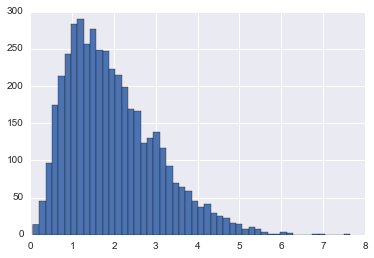

In [14]:
sig_df = cooc_df[cooc_df.p_fisher < 0.05]
plt.hist(list(numpy.log(sig_df.enrichment)), bins = 50);